In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

N = 1000

## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

In [2]:
def dist(x,i,j):
    return np.linalg.norm(x[i]-x[j])

## t-SNE visualization, for true labels

In [3]:

def visualize_tsne(n_components = 2, perplexities = [5, 10, 20, 40, 80], D=3, tsne_init='random', show_ticks=False):
    
    fname,fnamey=f"x_{D}d.dat",f"y_{D}d.dat"
    data=np.loadtxt("DATA/"+fname, delimiter='\t')
    y=np.loadtxt("DATA/"+fnamey,dtype=int)
    N=len(data)
    x=data

    np.random.seed(0)
    n_samples = N
    Np = len(perplexities)
    mycmap = ListedColormap(["blue","red","gold" ])
    from mpl_toolkits import mplot3d

#     %matplotlib notebook 
#     from matplotlib import interactive
#     interactive(True)
     
    yc = y.copy()
    if n_components == 3:
        fig = plt.figure(figsize=(3*Np, 2.7))
    elif n_components == 2:
        (fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))
        
    for i, perplexity in enumerate(perplexities):
        if n_components == 3:
            
            t0 = time()
            tsne = manifold.TSNE(n_components=n_components, init=tsne_init,
                                 random_state=0, perplexity=perplexity)
            Y = tsne.fit_transform(data)
            # removing outliers
            outliers = []
            for idx, el in enumerate(Y):
                if abs(np.max(el)) > 5:
                    outliers.append(idx)
            Yc = Y.copy()
            Y = np.delete(Y, outliers, 0)
            y = np.delete(yc, outliers, 0)

            t1 = time()
            ax = fig.add_subplot(1,5,i+1,projection='3d')
            ax.scatter(Y[:,0], Y[:,1],Y[:,2], s=5, c=y, depthshade=True, cmap=mycmap)
            ax.set_title(f"Perplexity={perplexity} D={D}")
            ax.tick_params(left=False,bottom=False)
            ax.xaxis.set_major_formatter(NullFormatter())
            ax.yaxis.set_major_formatter(NullFormatter())

            ax.axis('tight')
            plt.draw()

            X_all.append(Yc)
        elif n_components == 2:
            ax = subplots[i]
            t0 = time()
            tsne = manifold.TSNE(n_components=n_components, init=tsne_init,
                                 random_state=0, perplexity=perplexity)
            Y = tsne.fit_transform(data)
            t1 = time()
            ax.set_title(f"Perplexity={perplexity} D={D}")
            ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
            if not show_ticks:
                ax.tick_params(left=False,bottom=False)
                ax.xaxis.set_major_formatter(NullFormatter())
                ax.yaxis.set_major_formatter(NullFormatter())
            ax.axis('tight')
            plt.draw()
            X_all.append(Y)
    plt.show()
    return data, X_all, yc

    

In [4]:
from sklearn.cluster import DBSCAN
#from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)
        
def dbscan(data, X_all, y):

    # DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
    np.random.seed(12345)
    n_true_center=3
    #X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
    X2D = X_all[3] # best visualization above
    X = data
    y_true = y
    # distance
    print(dist(X,13,1))
    mdist = np.zeros(N)
    for i in range(N):
        dm = 1e100
        for j in range(N):
            if i!=j:
                dij = dist(X,i,j);
                if dij<dm:
                    dm = dij
        mdist[i] = dm
    mean_min_dist = mdist.mean()
    print("mean minimum distance between points: ",mean_min_dist)
    #eps_range = [0.01,0.1,0.5,1.0,10.]
    if mean_min_dist<10:
        r=mean_min_dist
    else:
        r = int(mean_min_dist)
    eps_range = [r,3*r,6*r,9*r,12*r]
    min_sample_range = [3,5,10,20]
    fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,18))
    for i, eps in enumerate(eps_range):
        for j, min_samples in enumerate(min_sample_range):
            model = DBSCAN(eps=eps, min_samples=min_samples)
            model.fit(X)
            y_hat = model.labels_
            plotting_ax(X2D,y_hat,ax[i,j])
            nmi=NMI(y_hat, y_true)
            ax[i,j].set_title('eps=%.2f, minPts=%i\nnmi=%.2f'%(eps,min_samples,nmi))
    plt.tight_layout(h_pad=0.5)
    plt.show()

## 1. The role of dimensions

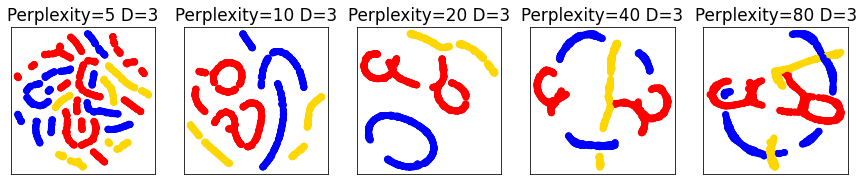

1552.6302096770091
mean minimum distance between points:  18.55757910124019


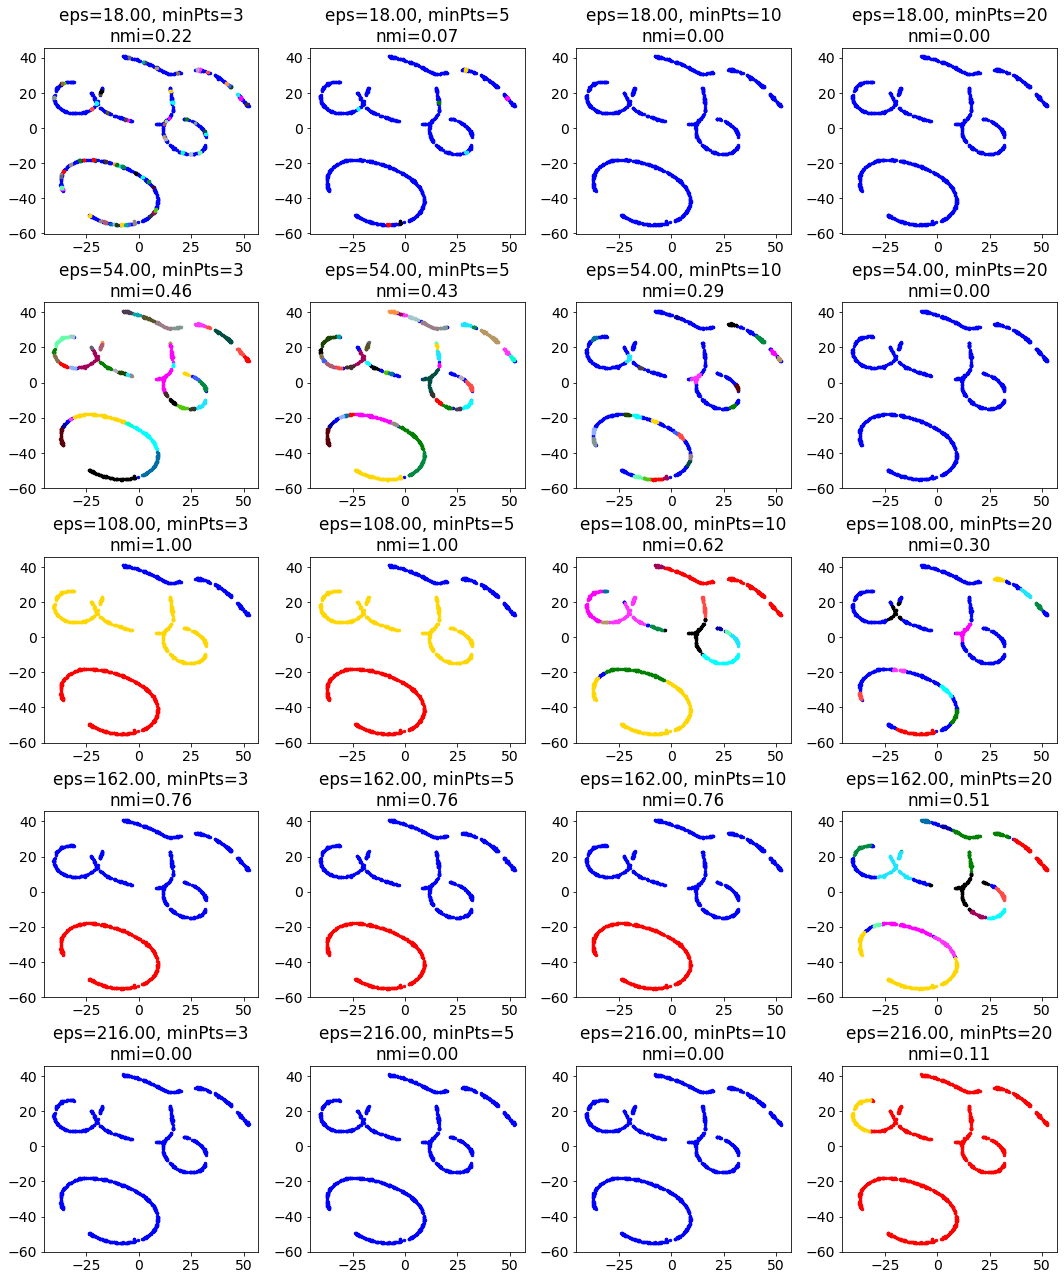

In [5]:
X_all = [None]
data, X_all, y = visualize_tsne(D=3)
dbscan(data, X_all, y)

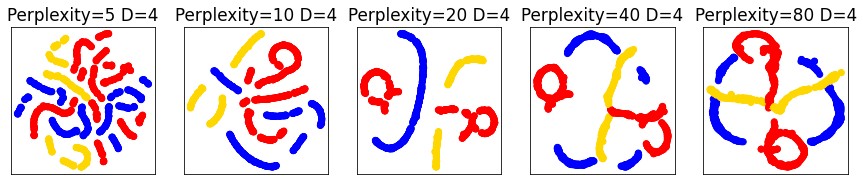

1268.4839912157263
mean minimum distance between points:  21.767814126488283


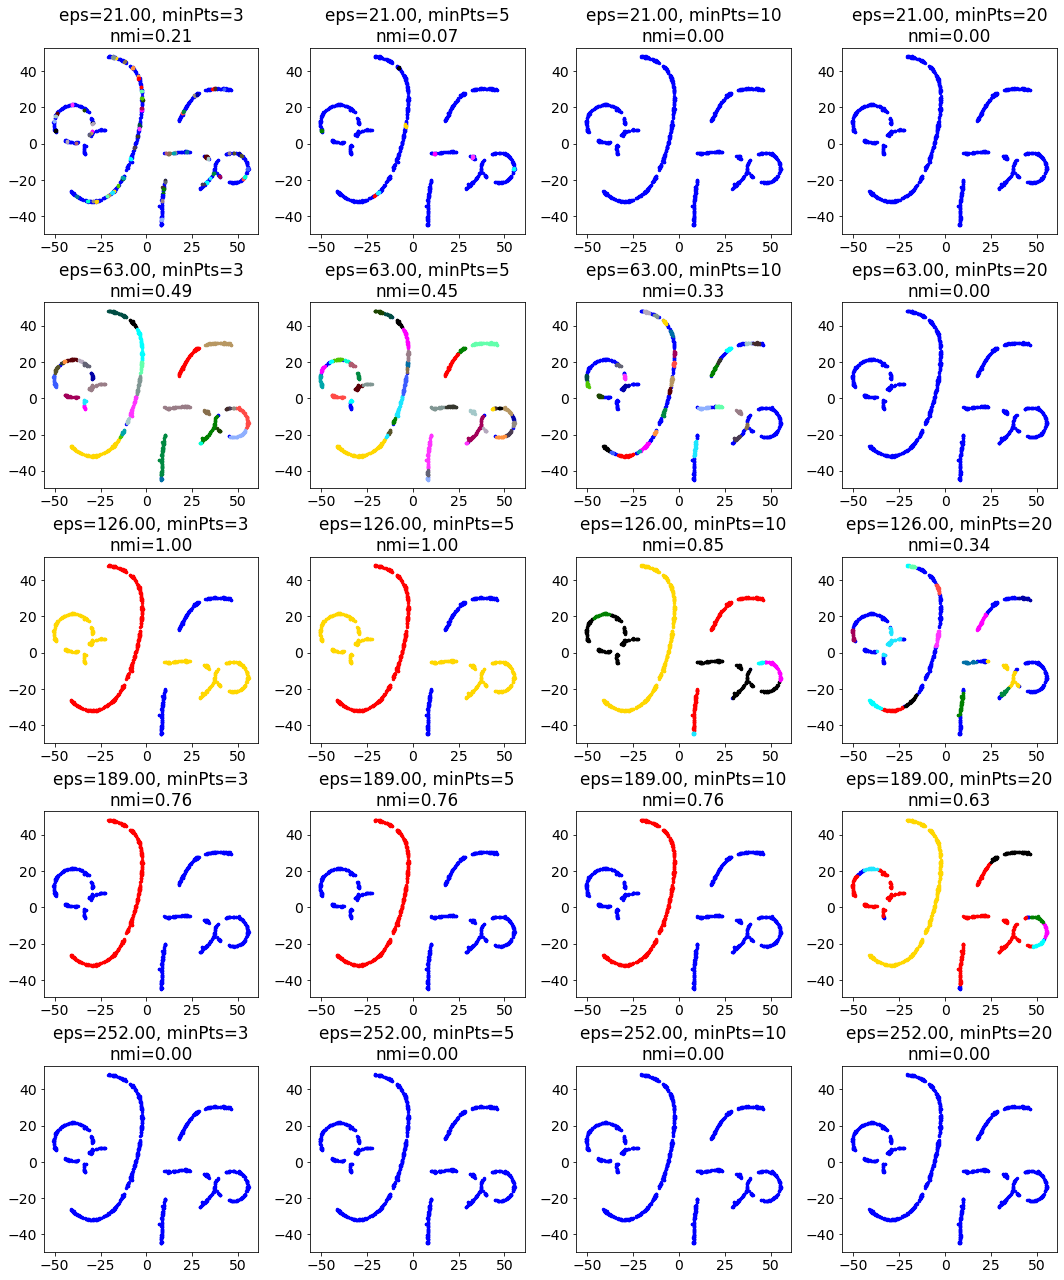

In [6]:
X_all = [None]
data, X_all, y = visualize_tsne(n_components=2, D=4)
dbscan(data, X_all, y)

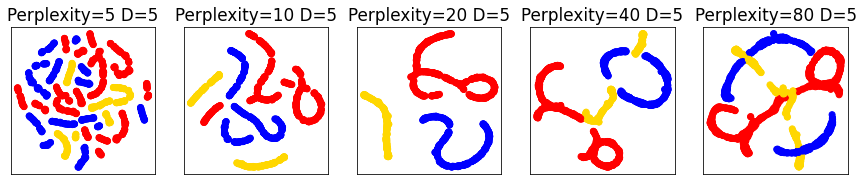

704.2788354479607
mean minimum distance between points:  25.06516532806731


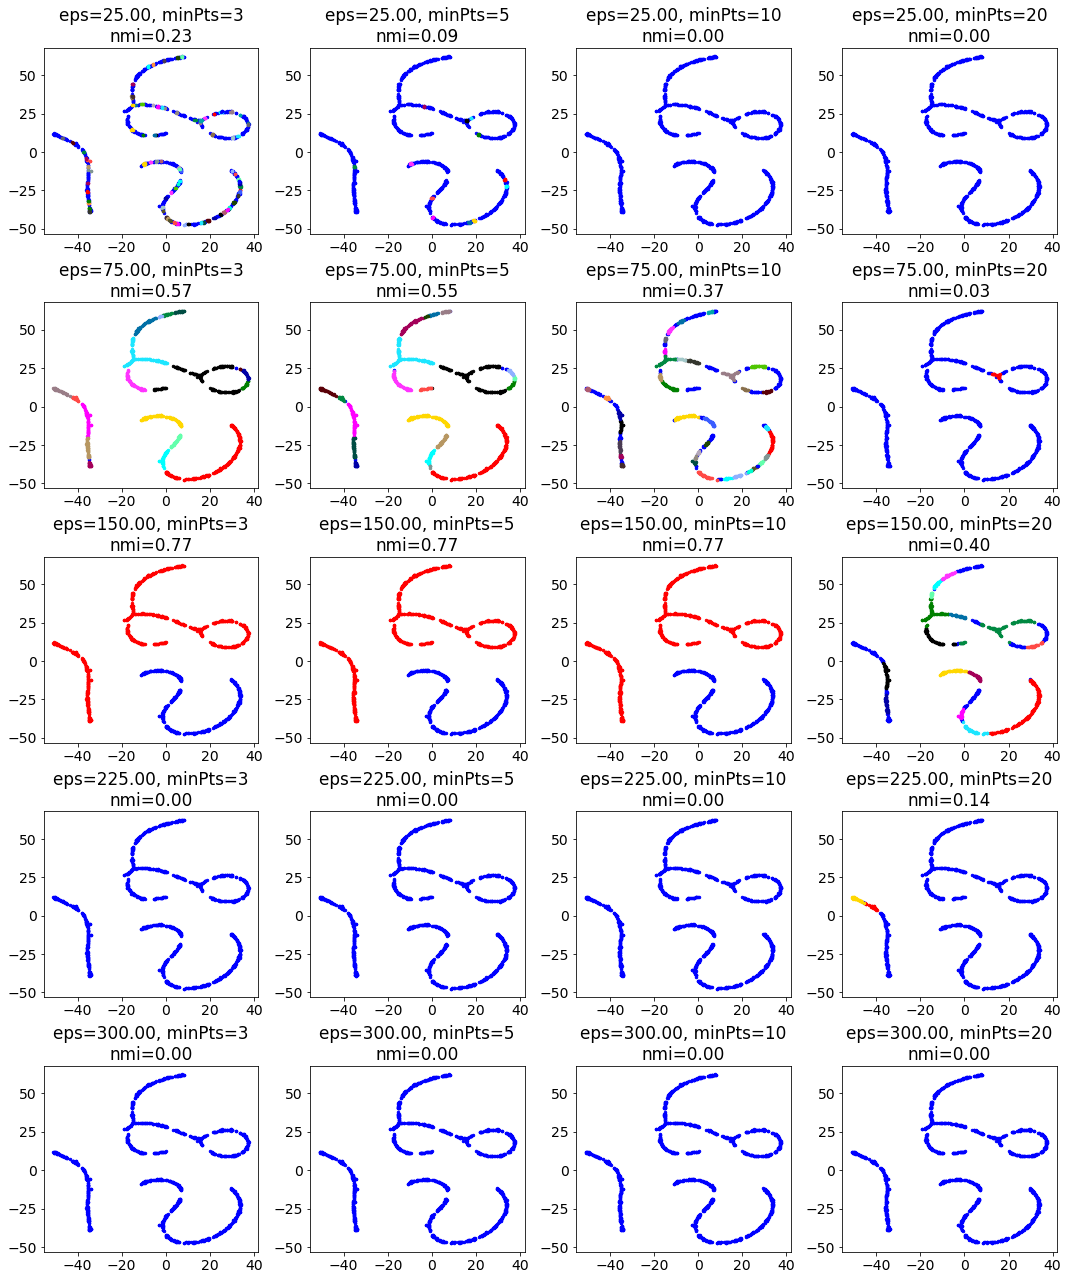

In [7]:
X_all = [None]
data, X_all, y = visualize_tsne(D=5)
dbscan(data, X_all, y)

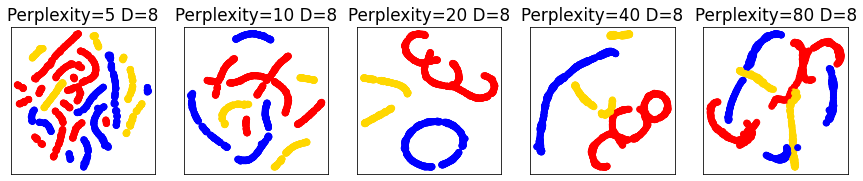

634.584624922146
mean minimum distance between points:  33.21529419242822


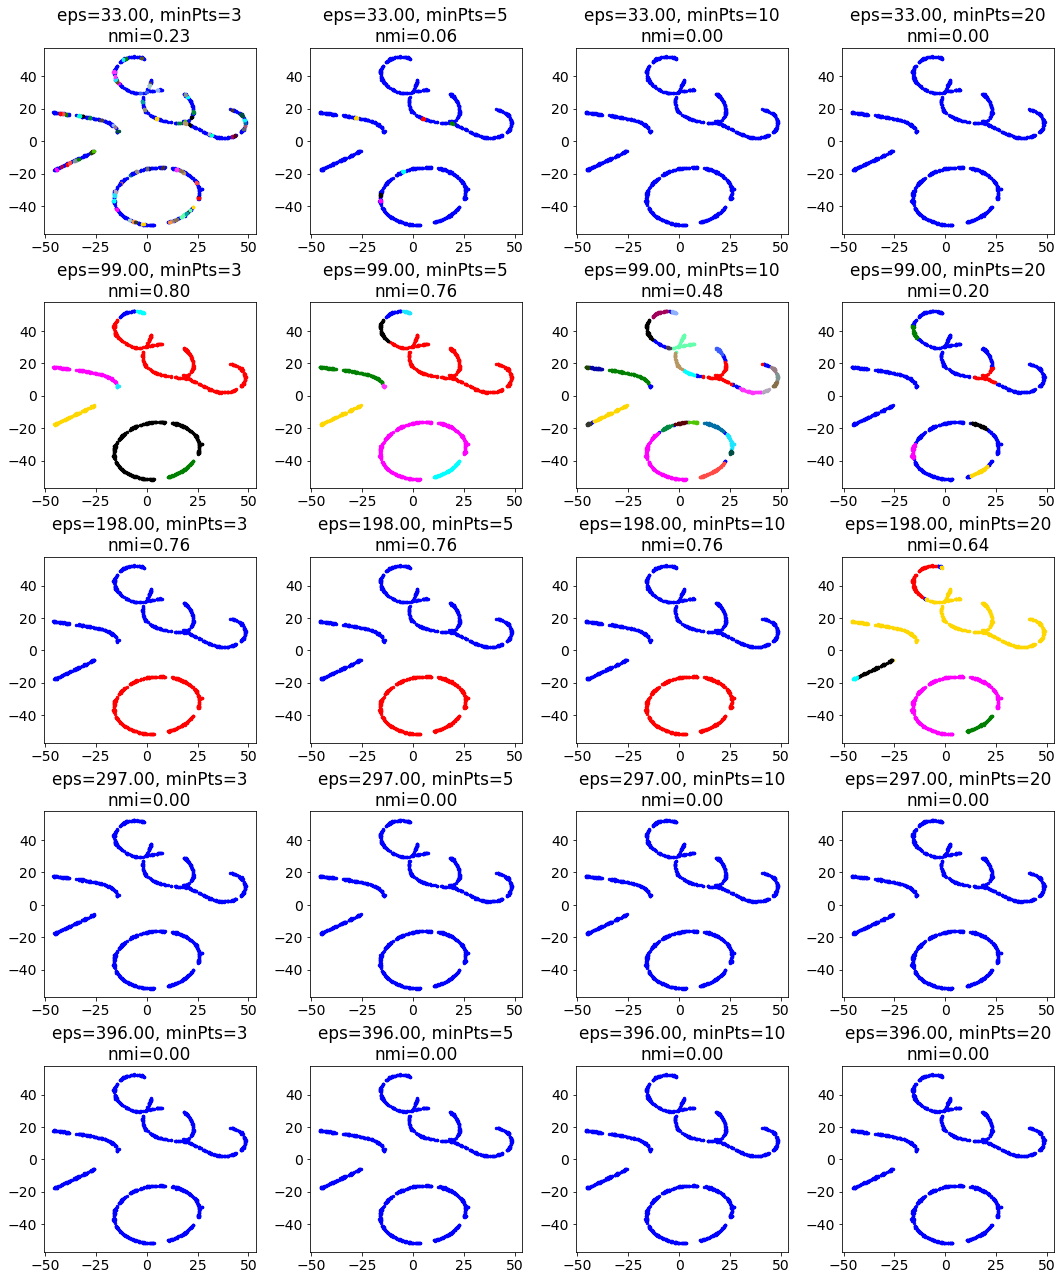

In [8]:
X_all = [None]
data, X_all, y = visualize_tsne(D=8)
dbscan(data, X_all, y)

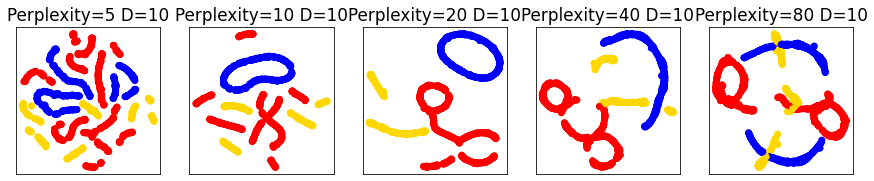

1176.101547559614
mean minimum distance between points:  38.19798664155697


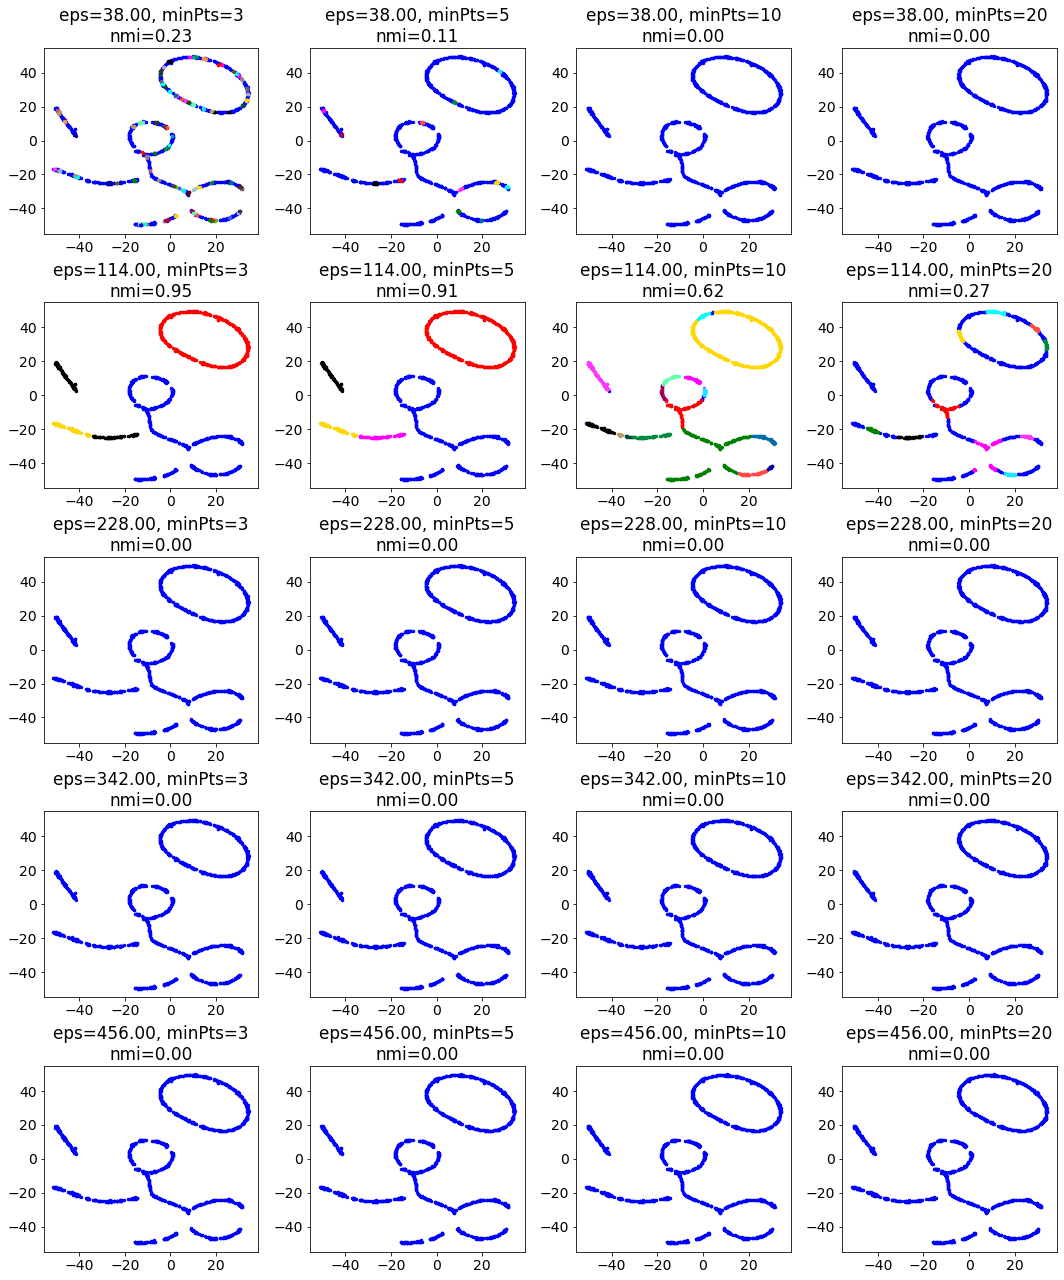

In [9]:
X_all = [None]
data, X_all, y = visualize_tsne(D=10)
dbscan(data, X_all, y)

__Study how visualization with t-SNE and clustering
with DBSCAN are affected by this increase in dimensionality.__

_t-SNE visualization (comparison between 3D and 10D)_ :<br>
Perplexity can be thought of as a "guess about the number of close neighbours a point has".<br>
For _perplexity = 5_ the results are very similar: the clusters are not easily discernable and it seems like they overlap each other. <br>
For _perplexity = 10_ the 3D case seems to show better results than the 10D case. <br>
For _perplexity = 20_, both cases show clusters that are easily discernable.<br>
For _perplexity = 40 and 80_ both cases show quite bad results. <br>
__Conclusion: The results suggest that the best choice of the perplexity is not affected by the noise.__ 


## 2. The role of perplexity in t-SNE

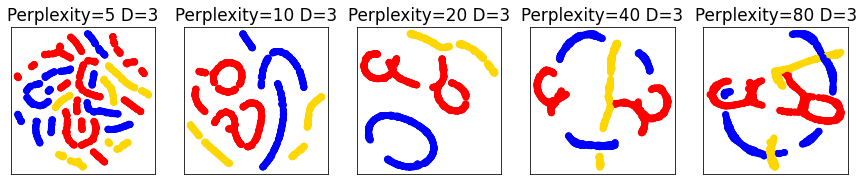

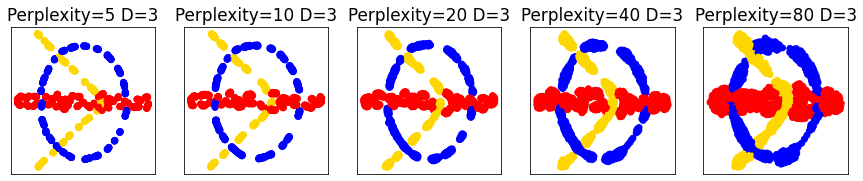

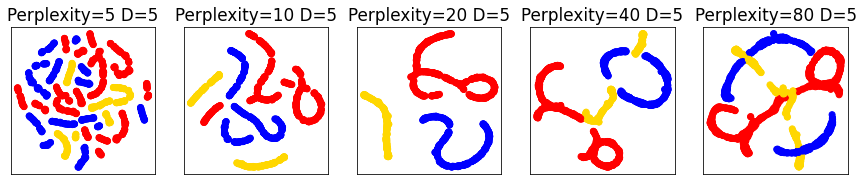

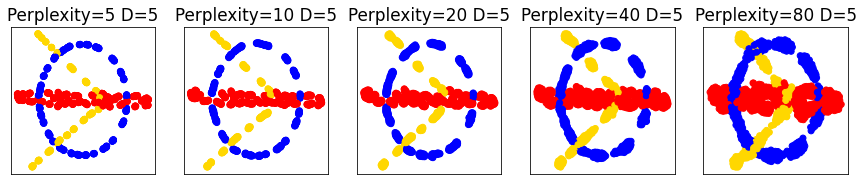

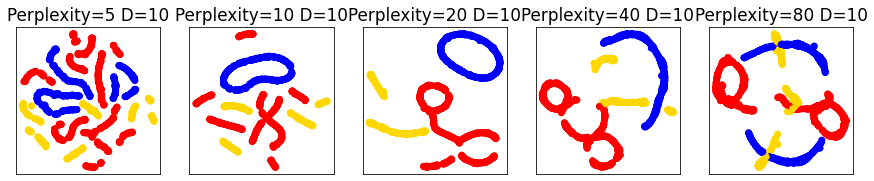

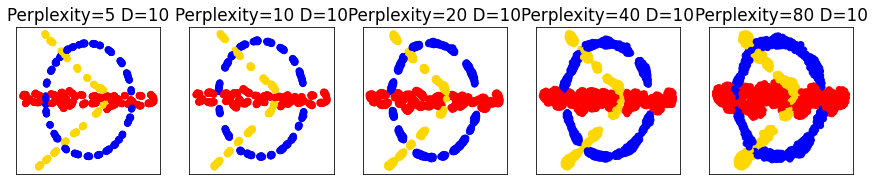

In [10]:
visualize_tsne(D=3)
visualize_tsne(D=3, tsne_init='pca')
visualize_tsne(D=5)
visualize_tsne(D=5, tsne_init='pca')
visualize_tsne(D=10)
_, _, _ =visualize_tsne(D=10, tsne_init='pca')

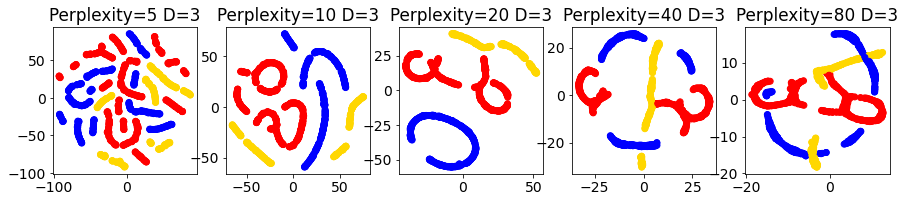

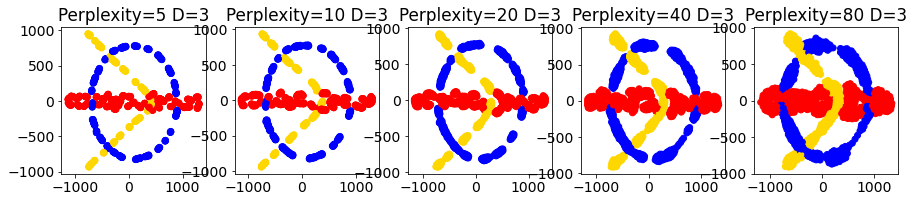

In [11]:
visualize_tsne(D=3, show_ticks=True)
_, _, _ = visualize_tsne(D=3, tsne_init='pca', show_ticks=True)

<b>patterns observed by varying the perplexity of t-SNE</b>
<ul>
<li> for low perplexity we observe that we obtain no clear patterns in the visualization, as it does not implies a high enough density of points for clusterization
<li> as we increase the perplexity (10, 20) we observe that clusters are starting to form, and eventually we arrive at the most ideal visualization
<li> increasing the perplexity more, the data is condensed towards the same space and the clusters start to overlap
</ul>

<b>do they vary if t-SNE is initialized by using principal component analysis (init=’pca’)?</b>
<br>
if we initialize by PCA the data is already clusterized in a certain way. in this context, if we use a low perplexity we observe that the points are much denser clusterized than in the case of high perplexity.  however, the patterns do not change with perplexity.

## 3. Tuning of “eps” and “minPts” in DBSCAN algorithm for clustering

_DBSCAN clustering (comparison between 3D and 10D)_: <br>
Since for 3D data we considered the 2D shape given to us by t-SNE when Perplexity = 20 as being the best visualization of our original data in 2D space, we'll use that as a reference for finding the best visualization for our 10D dataset, and successively use it also for showing the results of DBSCAN clustering.
The best visualization is obtained again when perplexity is 20 for 10D data.
The best nmi for 𝐷=3 is obtained when 𝜖=108 and minPts = 3 and 5.
The best nmi for 𝐷=10 is obtained when 𝜖=114 and minPts = 3 and 5. So close it's pretty close and we can say that an increase in dimensionality led to very similar results in terms of what the best 𝜖 and minPts are.
When it comes to nmi score, it slightly decreased from 1 to 0.95.

## k-distance plot

In [33]:
def k_dist_mean(D, k_array=[3, 5, 10, 20]):
    (fig, subplots) = plt.subplots(1, len(k_array), figsize=(6 * len(k_array), 4))
    fname=f"x_{D}d.dat"
    data=np.loadtxt("DATA/"+fname, delimiter='\t')
    N=len(data)
    for idx, k in enumerate(k_array):
        mdist = np.zeros(N)
        for i in range(N):
            k_dist = [1e100] * k
            for j in range(N):
                if i!=j:
                    dij = dist(X,i,j);
                    if dij<k_dist[-1]:
                        k_dist[-1] = dij
                        k_dist.sort()
            mdist[i] = np.mean(k_dist)
        mdist.sort()
        ax = subplots[idx]
        ax.plot(mdist[::-1])
        ax.set_title(f"{k}-distance plot for {D}D")
        ax.set_xlabel("Index")
        ax.set_ylabel(f"mean of min {k}-distances")
        ax.axis('tight')
        plt.draw()
    plt.show()

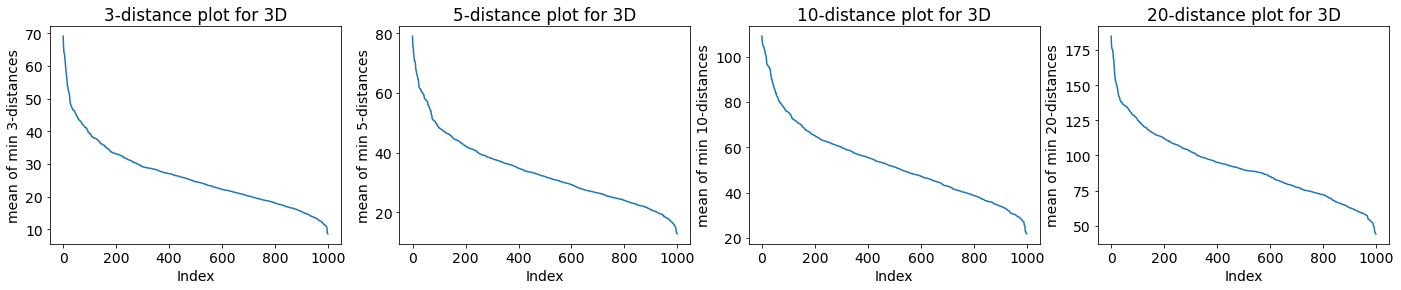

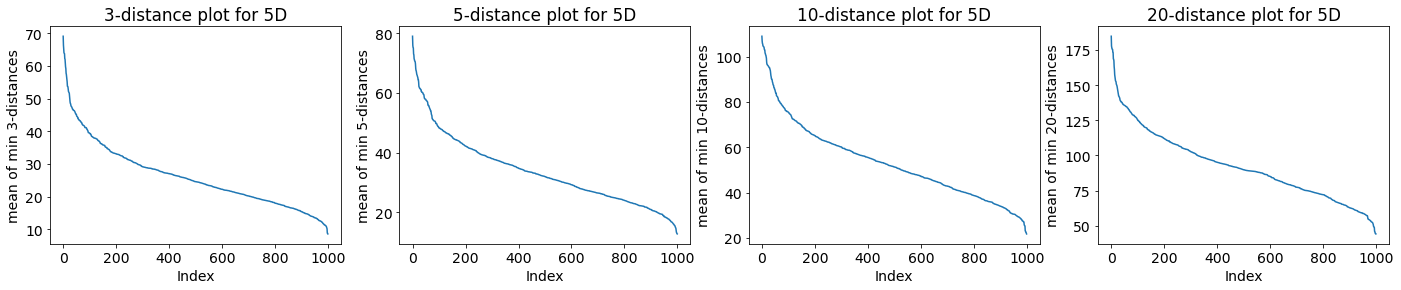

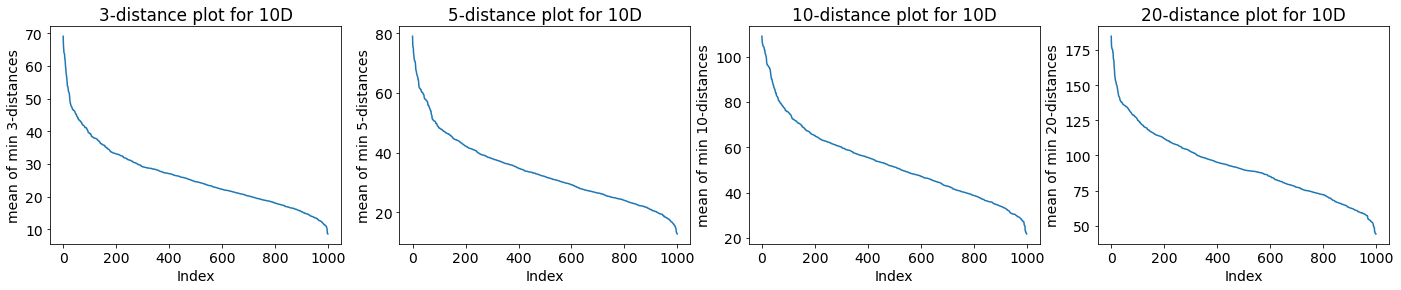

In [34]:
k_dist_mean(3)
k_dist_mean(5)
k_dist_mean(10)

We get that the knee optimal value for eps is increasing with k (as expected), but it is not obviously affected by extra noisy dimensions.<br>
The optimal values are around:
<ul>
    <li> eps = 40 for k=3
    <li> eps = 50 for k=5
    <li> eps = 80 for k=10
    <li> eps = 125 for k=20
</ul>
We notice that the best values of nmi are obtained for eps around 100. Therefore, the optimal values given by the knee are actually at the half.

## visualizing 3 components with t-SNE

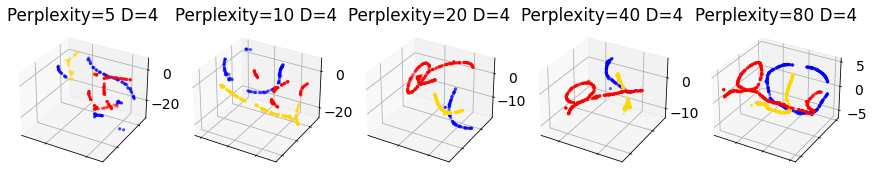

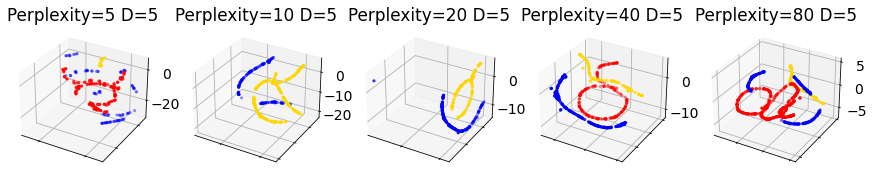

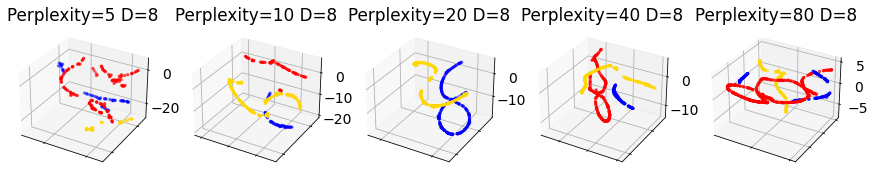

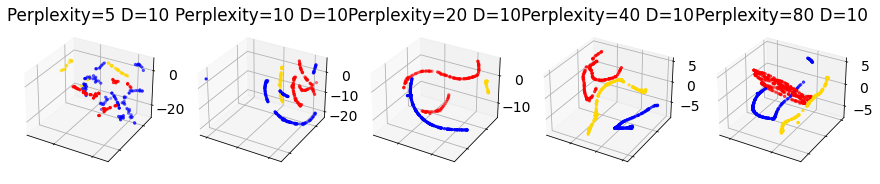

In [36]:
visualize_tsne(n_components=3, D=4)
visualize_tsne(n_components=3, D=5)
visualize_tsne(n_components=3, D=8)
_, _, _ = visualize_tsne(n_components=3, D=10)

By reducing the dimensionality of the data to 3D we expect to obtain the original dataset (D=3 - w/o adding the noisy dimensions). We notice that for low perplexities we do not get the desired result. However, it seems that t-SNE starts to reconstruct the original dataset when using higher perplexities.